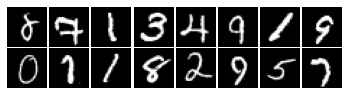

In [1]:
import tensorflow as tf
import matplotlib.pylab as plt

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
train_images = (train_images - 127.5) / 127.5   # Normalize the input images

# Prepare dataloader for training
batch_size = 256
dataloader = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(100000).batch(batch_size)
# Set image shape
img_shape = train_images[0].shape

# Plot some training images
real_batch, _ = next(iter(dataloader))
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(8,8,i+1)
    plt.imshow(real_batch[i]*127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.subplots_adjust(hspace=0.025, wspace=0.05)
plt.show()

In [2]:
# Vanilla GAN Training

from GAN_tensorflow import *

dim_latent = 100
G = Generator(img_shape=img_shape, dim_latent=dim_latent, g_dims=[128,256,512,1024])
D = Discriminator(img_shape=img_shape, d_dims=[512, 256])

optimizer_G = tf.optimizers.Adam(lr=1e-3, beta_1=0.5, beta_2=0.999)
optimizer_D = tf.optimizers.Adam(lr=1e-3, beta_1=0.5, beta_2=0.999)

Train(epoch=80, dim_latent=dim_latent,  dataloader=dataloader, G=G, D=D, 
        optimizer_G=optimizer_G, optimizer_D=optimizer_D, verbose_freq=20)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 20 / D loss: 1.016 / G loss: 1.530
Epoch 40 / D loss: 1.078 / G loss: 1.671
Epoch 60 / D loss: 1.221 / G loss: 1.116
Epoch 80 / D loss: 1.424 / G loss: 0.426


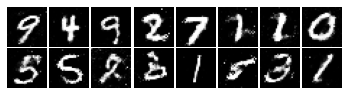

In [3]:
# Examples of Generated Images

z = tf.random.normal([16, dim_latent])
gen_imgs = G(z, training=False)
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(8,8,i+1)
    plt.imshow(gen_imgs[i]*127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.subplots_adjust(hspace=0.025, wspace=0.05)
plt.show()

In [4]:
# CGAN Training

from cGAN_tensorflow import *

dim_latent = 128
num_class = 10
G = Generator(img_shape=img_shape, num_class=num_class, dim_latent=dim_latent, g_dims=[128,256,512,1024])
D = Discriminator(img_shape=img_shape, num_class=num_class, d_dims=[512,256])

optimizer_G = tf.optimizers.Adam(lr=1e-3, beta_1=0.5, beta_2=0.999)
optimizer_D = tf.optimizers.Adam(lr=1e-3, beta_1=0.5, beta_2=0.999)

Train(epoch=50, dim_latent=dim_latent, dataloader=dataloader, G=G, D=D,
        optimizer_G=optimizer_G, optimizer_D=optimizer_D, verbose_freq=10)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10 / D loss: 1.115 / G loss: 1.231
Epoch 20 / D loss: 1.313 / G loss: 1.344
Epoch 30 / D loss: 1.195 / G loss: 0.848
Epoch 40 / D loss: 1.159 / G loss: 0.819
Epoch 50 / D loss: 1.457 / G loss: 1.097


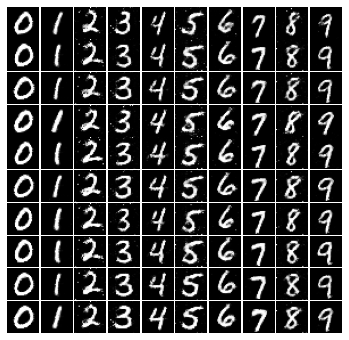

In [5]:
# Examples of Generated Images
import torch
num_sample = num_class**2

# Fix noise z to generate conditioned result
z = torch.zeros(num_sample, dim_latent)
for i in range(num_class):
    z[i*num_class] = torch.rand(1, dim_latent)
    for j in range(1, num_class):
        z[i*num_class + j] = z[i*num_class]

# Make label vectors
temp = torch.zeros(num_class, 1)
for i in range(num_class):  temp[i, 0] = i
temp_y = torch.zeros(num_sample, 1)
for i in range(num_class):  temp_y[i*num_class: (i+1)*num_class] = temp
labels = torch.zeros(num_sample, num_class).scatter_(1, temp_y.type(torch.LongTensor), 1)

z = tf.convert_to_tensor(z.numpy())
labels = tf.convert_to_tensor(labels.numpy())

gen_imgs = G((z, labels), training=False)
plt.figure(figsize=(6,6))
for i in range(num_sample):
    plt.subplot(num_class,num_class,i+1)
    plt.imshow(gen_imgs[i]*127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.subplots_adjust(hspace=0.025, wspace=0.05)
plt.show()
